In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [7]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [8]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [32]:
df = load_pd_df("df_analysis.feather")
hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()


# Cross Section Expectation and perception

In [33]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols

['delta_pe_MY_error_act',
 'delta_pe_MY_error_act_MY',
 'delta_pe_MY_error_act_WY',
 'pi_exp_MY_error_act',
 'pi_perc_MY__S_error_act',
 'pi_perc_MY_error_act']

In [34]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (8632, 2)
delta_pe_MY_error_act_MY (114252, 2)
delta_pe_MY_error_act_WY (108440, 2)
pi_exp_MY_error_act (8633, 2)
pi_perc_MY__S_error_act (6692, 2)
pi_perc_MY_error_act (6692, 2)


In [35]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\~{\pi}^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$"
}

In [38]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'eduschool_txt',
        'eduwork_txt',
        # 'wealth_bank_midpoint', 
        'savings_planned', 
        # 'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [39]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': float, 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO', 'eduschool_txt': 'category', 'savings_planned': float,
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [40]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col].dropna(), dtype=bool, )
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [41]:
# multiple ols models
lst_ols_mods, lst_dfbetas, lst_ols_data = [], [], []
_ = ""
for col in lst_error_cols + ['delta_pe_MY_error_act']:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    
    if col == "delta_pe_MY_error_act" and _ == "":
        d = d #[[i for i in d.columns if i not in ['hhsize']]] #', 'is_unempl']]]
        _ = "x"
    else:
        d = d[[i for i in d.columns if 'risk' not in i]]
    d = d.dropna()
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    
    lst_ols_data.append((d[col], d.drop(col, axis=1)))
    # dfbeta = get_dfbetas(ols.model.exog, ols.resid.values)
    # lst_dfbetas.append((d, pd.DataFrame(dfbeta, index=d.index, columns=d.columns[:-1])))
    lst_ols_mods.append(ols)

In [42]:
out = get_statsmodels_summary(lst_ols_mods, seperator=" ", is_filt_sig=True)
save_pd_df(out, 'tab_cross_section_error.csv', GRAPHS_DIR)

In [43]:
out

,delta_pe_MY_error_act,delta_pe_MY_error_act_6,delta_pe_MY_error_act_MY,delta_pe_MY_error_act_WY,pi_exp_MY_error_act,pi_perc_MY__S_error_act,pi_perc_MY_error_act
eduwork_txtPromotion abgeschlossen,-0.074 [-0.187],-0.19 [-0.923],0.001 [1.07],0.001 [0.962],-0.204 [-1.374],-0.078 ** [-2.528],-0.1 *** [-2.869]
hhchildren3.0,-0.183 [-0.451],0.07 [0.321],0.002 [1.608],0.003 *** [2.823],-0.089 [-0.567],-0.184 *** [-6.03],-0.212 *** [-6.134]
hhchildren2.0,-0.22 [-0.805],0.135 [1.01],0.002 ** [2.396],0.002 ** [2.28],-0.015 [-0.16],-0.196 *** [-10.026],-0.224 *** [-10.071]
hhchildren1.0,0.09 [0.387],0.175 [1.45],0.001 [1.054],0.001 ** [2.24],0.007 [0.084],-0.182 *** [-10.493],-0.179 *** [-9.111]
hhchildren0.0,-0.092 [-0.57],0.062 [0.749],0.0 [0.573],0.001 [1.334],-0.066 [-1.095],-0.2 *** [-16.822],-0.209 *** [-15.545]
eduwork_txtberuflich-schulische Ausbildung abgeschlossen,-0.555 ** [-2.198],0.143 [1.047],0.001 ** [1.99],0.002 ** [2.41],0.052 [0.525],-0.07 *** [-3.641],-0.08 *** [-3.686]
eduwork_txtanderer Abschluss,-0.088 [-0.172],-0.254 [-1.06],0.002 [1.503],0.003 ** [1.979],-0.219 [-1.269],-0.011 [-0.318],0.022 [0.572]
eduwork_txtStudent,0.764 [1.198],0.349 [0.942],-0.003 * [-1.913],-0.004 ** [-1.969],0.254 [0.954],-0.084 [-1.519],-0.062 [-0.986]
is_food_shop,0.652 ** [2.021],-0.622 *** [-3.849],-0.001 [-1.383],-0.003 *** [-3.051],-0.332 *** [-2.853],0.093 *** [4.15],0.075 *** [2.948]
savings_planned,0.212 [1.314],0.22 *** [2.723],0.001 [1.589],0.001 * [1.726],0.147 ** [2.528],-0.002 [-0.169],0.002 [0.178]


## risk aversion delta_pe

In [44]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]
sub2.index = [int(float(i.split('riskaversion')[-1])) for i in sub2.index]

sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
mean = sub.delta_pe_MY_error_act.mean()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)
sub.index = [int(float(i)) for i in sub.index]

sub = sub.join(sub2)

In [45]:
sub3 = df[['id', 'riskaversion', 'savings_planned']].dropna().copy()
sub3['savings_planned'] = sub3['savings_planned'].replace({1: 0}) * -1

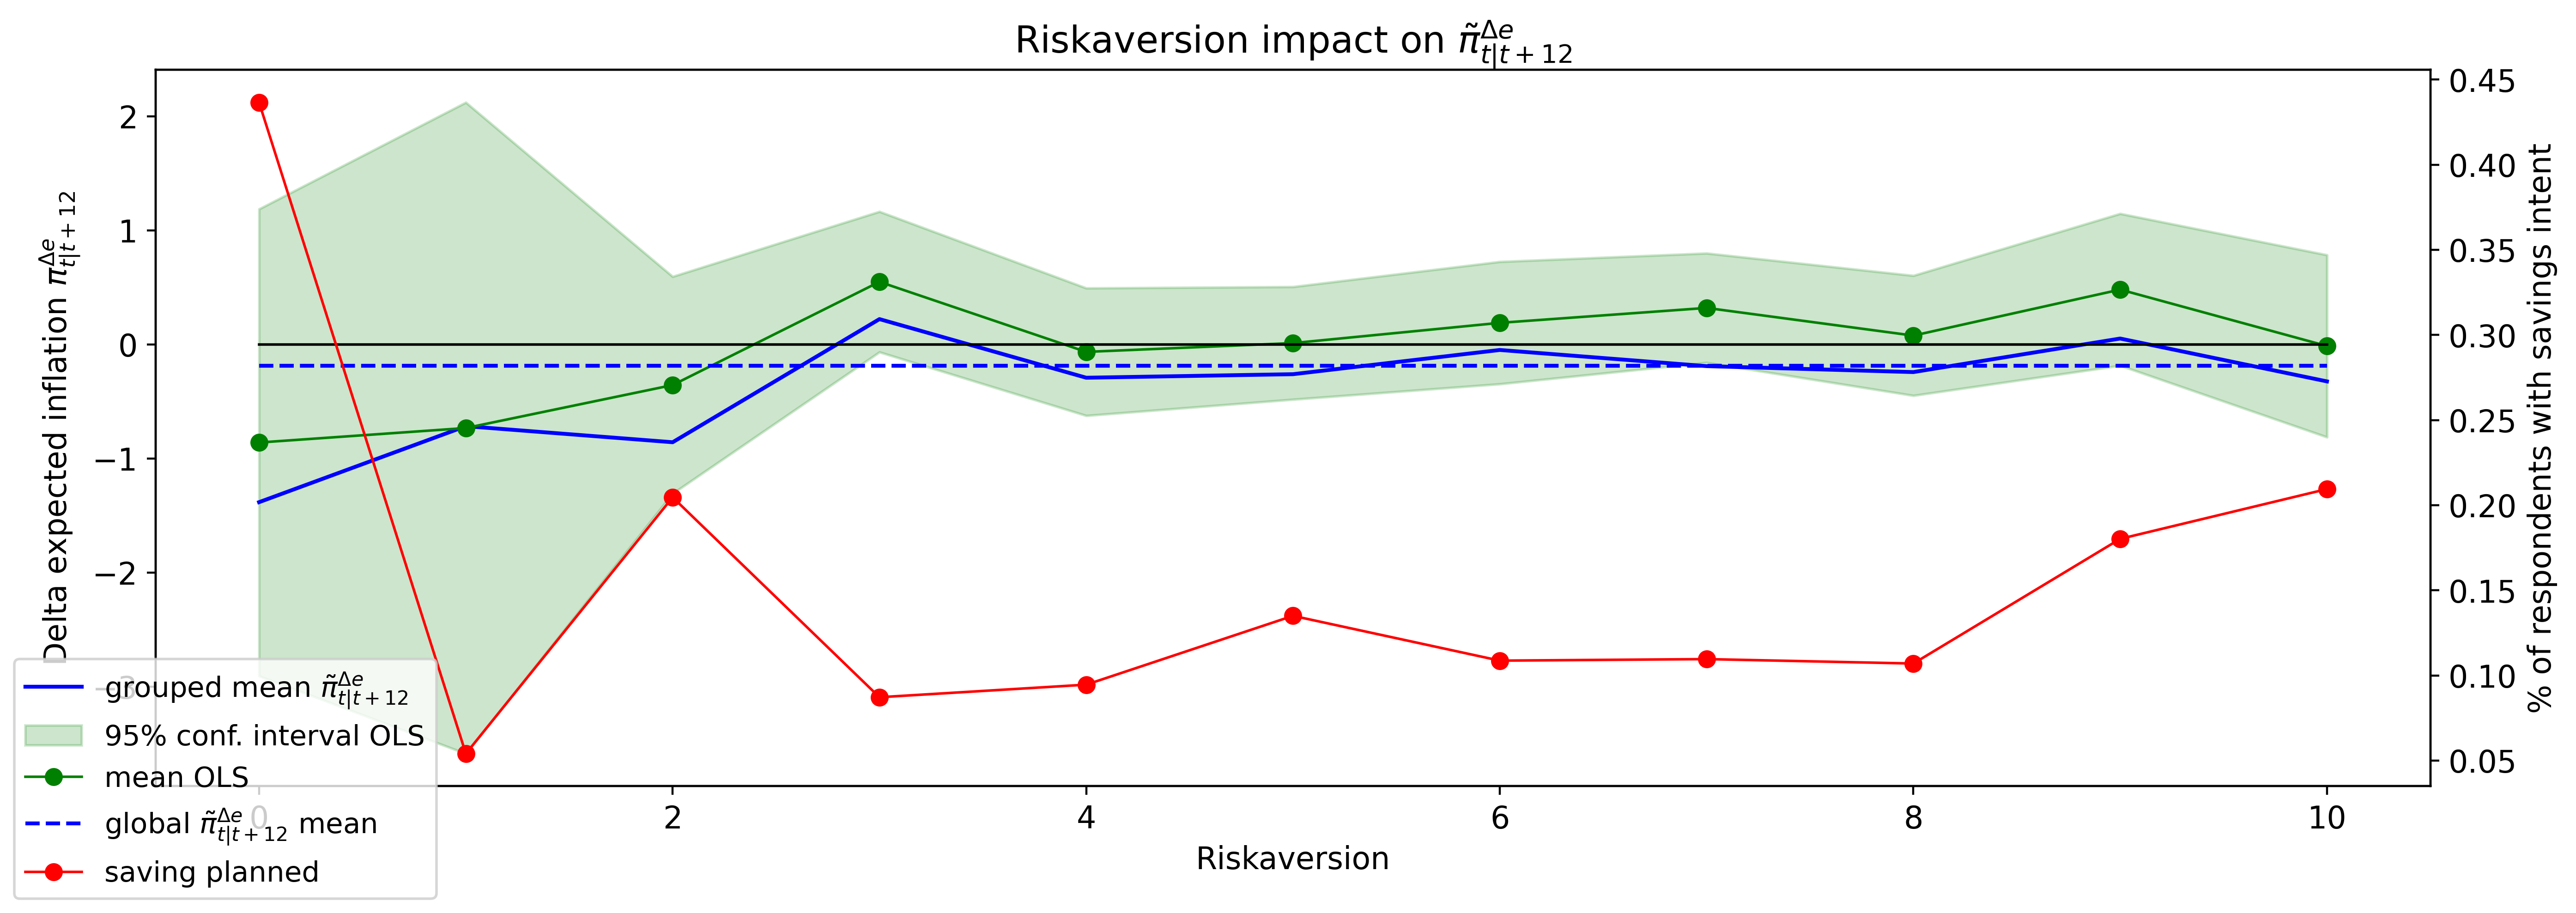

In [46]:
fig, ax = get_fig_subplots(figsize=(14,5), dpi=400)
ax.plot(sub['mean'], color='blue', label='grouped mean $\~{\pi}^{\Delta e}_{t|t+12}$')
ax.fill_between(sub.index, sub['conf_lower'], sub['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub['coef'], lw=1, marker='o', color='green', label='mean OLS')
ax.plot(sub.index, list([0] * len(sub2)), color='black', lw=1,)
ax.plot(sub.index, list([mean] * len(sub)), label='global $\~{\pi}^{\Delta e}_{t|t+12}$ mean', color='blue', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(sub3.groupby('riskaversion').savings_planned.mean(), color='red', lw=1, marker='o', label='saving planned')

ax.set_xlabel("Riskaversion")
ax2.set_ylabel("% of respondents with savings intent")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\~{\pi}^{\Delta e}_{t|t+12}$")

fig.legend(loc='lower left', prop={'size': 11})

fig.tight_layout()
save_fig(fig, "riskaversion.png", GRAPHS_DIR)